In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# How to infer parameters from ATAC- and RNA-seq?

**Dataset handling part:**
1. annotated ATAC-seq
2. select distant regions + promotors for all genes
- if gene is in ATAC and not in RNA-seq - SKIPPING
- if gene is in RNA seq and not in ATAC-seq
- if gene have all regulators - cool, otherwise, set missing to 0
3. sub-annotate distant regions into promotors and enhancers (+ silencers if data is available)

**General part:** <br>
Write script that generates list of vectors of size (n_genes, 1) for the given sample:
- enhancers (1 if there are ANY open enhancers for this gene, returns en - number of enhancers)
- silencers (same, but sn)
- promotors (just vector)

for the future - we can be more sure in the enhancer/silencer if there is a detectable footprint

--> get vectors for each dataset
--> try with set constants

Data prerequisites:
1. both RNA-seq and ATAC-seq
2. annotation column (UTR/promotor/distal)
3. closest gene column for each region

Here we will use ATAC-seq and RNA-seq annotated data of the mouse postnatal P0 developmental stage. You can find the raw data on the ENCODE portal:

1. [RNA-seq](https://www.encodeproject.org/organism-development-series/ENCSR377ZLZ/)
2. [ATAC-seq](https://www.encodeproject.org/organism-development-series/ENCSR377ZLZ/)

We used [Homer tool](http://homer.ucsd.edu/homer/ngs/annotation.html) to annotate peaks for this data. If we have both ATAC-seq and RNA-seq data in the datasets folder, we can perform annotation by running:

```
annotatePeaks.pl ./datasets/postnatalP0_heart_ATAC.bed mm8 -gene ./datasets/postnatalP0_heart_RNA_simplif.tsv
```



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
atac_annotated = pd.read_csv("/content/drive/MyDrive/data/annotatesP0_out.txt", sep='\t')

In [ ]:
atac_annotated.drop(columns=['Strand', atac_annotated.columns[-1]], inplace=True)
atac_annotated.head(3)

,PeakID (cmd=annotatePeaks.pl ./datasets/postnatalP0_heart_ATAC.bed mm8 -gene ./datasets/postnatalP0_heart_RNA_simplif.tsv),Chr,Start,End,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type
0,Peak_6436,chr2,170209113,170209727,1000,NaN,"intron (NM_001013369, intron 3 of 3)","intron (NM_001013369, intron 3 of 3)",-6288,NR_040367,100502946.0,Mm.421284,NR_040367,ENSMUSG00000085495,Gm16796,-,"predicted gene, 16796",ncRNA
1,Peak_9468,chr3,138053928,138054421,1000,NaN,"intron (NM_001355052, intron 8 of 21)","intron (NM_001355052, intron 8 of 21)",14866,NM_008642,17777.0,Mm.2941,NM_008642,ENSMUSG00000028158,Mttp,1810043K16Rik|MTP,microsomal triglyceride transfer protein,protein-coding
2,Peak_15494,chr10,5068491,5069575,1000,NaN,"intron (NM_001347732, intron 55 of 145)",Lx2|LINE|L1,-82801,NM_001079686,64009.0,Mm.331626,NM_022027,ENSMUSG00000096054,Syne1,8B|A330049M09Rik|BE692247|C130039F11Rik|CPG2|K...,"spectrin repeat containing, nuclear envelope 1",protein-coding


In [ ]:
atac_annotated["Ann_short"] = atac_annotated["Annotation"].apply(lambda x: x[:x.find('(')] if '(' in x else x)
atac_annotated["Ann_short"].unique()

array(['intron ', 'Intergenic', 'promoter-TSS ', "3' UTR ", 'TTS ',
       'non-coding ', 'exon ', "5' UTR "], dtype=object)

In [ ]:
def enh_sil_ann(x):
  x = str(x)
  if 'enhan' in x:
    return 'enhancer'
  elif 'silen' in x:
    return 'silencer'
  else:
    return None


atac_annotated["Enhancer/Silencer"] = atac_annotated["Gene Description"].apply(lambda x: enh_sil_ann(x))
atac_annotated["Enhancer/Silencer"].unique()

array([None, 'enhancer', 'silencer'], dtype=object)

In [ ]:
atac_annotated["Gene Type"].unique()

array(['ncRNA', 'protein-coding', nan, 'pseudo', 'snoRNA', 'snRNA',
       'rRNA', 'scRNA'], dtype=object)

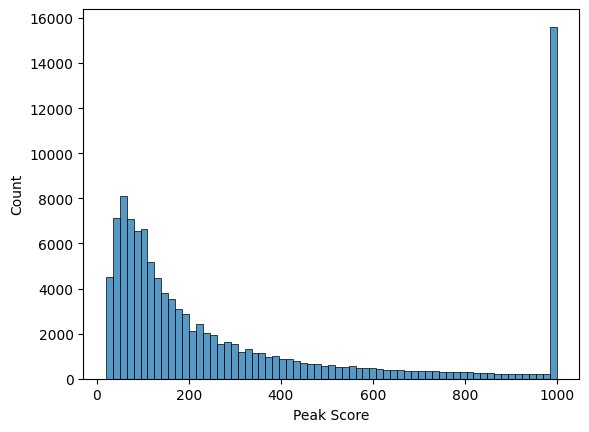

In [ ]:
sns.histplot(data=atac_annotated, x='Peak Score');

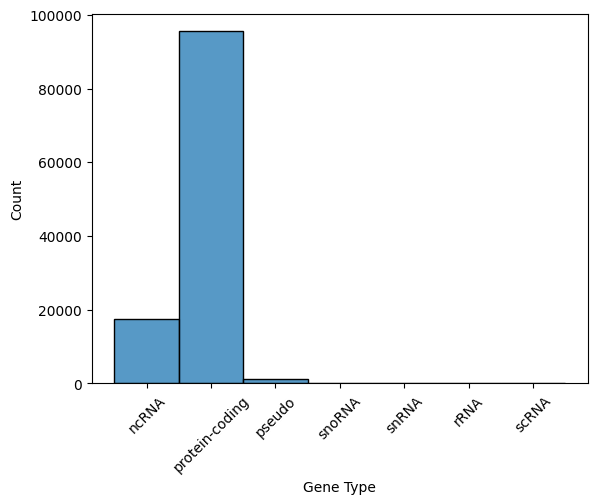

In [ ]:
sns.histplot(data=atac_annotated, x='Gene Type')
plt.xticks(rotation=45)
plt.show()

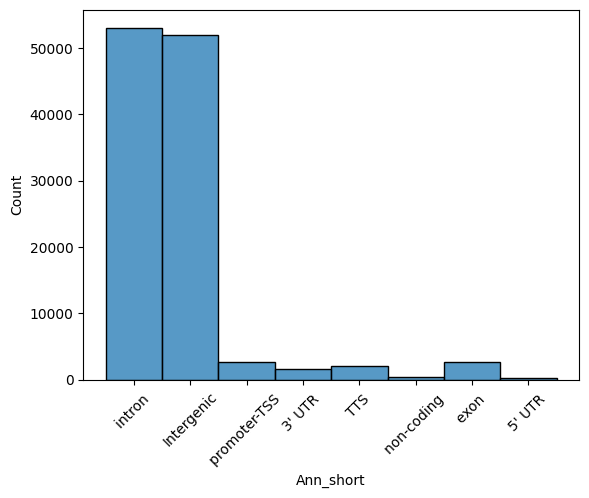

In [ ]:
sns.histplot(data=atac_annotated, x='Ann_short')
plt.xticks(rotation=45)
plt.show()

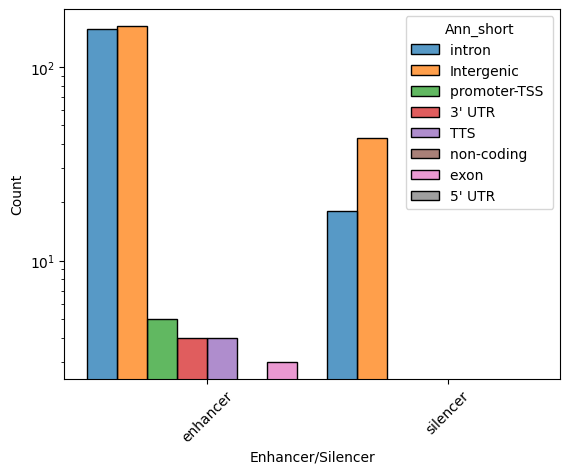

In [ ]:
sns.histplot(data=atac_annotated, hue='Ann_short', x='Enhancer/Silencer',  multiple="dodge")
plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

In [ ]:
enh_sil = atac_annotated[atac_annotated['Enhancer/Silencer'].isin(['enhancer', 'silencer'])]

In [ ]:
atac_annotated.groupby(['Enhancer/Silencer'])['End'].count()

Enhancer/Silencer
enhancer    337
silencer     61
Name: End, dtype: int64

In [ ]:
atac_annotated.groupby(['Ann_short'])['End'].count()

Ann_short
3' UTR            1574
5' UTR             241
Intergenic       52008
TTS               1983
exon              2632
intron           53118
non-coding         447
promoter-TSS      2605
Name: End, dtype: int64

In [ ]:
atac_annotated.shape

(114608, 20)

In [ ]:
enh_sil.shape

(398, 20)

In [ ]:
rna = pd.read_csv("/content/drive/MyDrive/data/postnatalP0_heart_RNA_simplif.tsv", sep=' ')
rna.head(3)

,gene_id,transcript_id(s),length,effective_length,TPM,FPKM
0,10000,10000,72.0,0.0,0.0,0.0
1,10001,10001,73.0,0.0,0.0,0.0
2,10002,10002,73.0,0.0,0.0,0.0


In [ ]:
rna.columns

Index(['gene_id', 'transcript_id(s)', 'length', 'effective_length', 'TPM',
       'FPKM'],
      dtype='object')

In [ ]:
rna.describe()

,length,effective_length,TPM,FPKM
count,81881.000000,81881.000000,81881.000000,81881.000000
mean,1069.459570,866.327893,12.212845,17.855354
std,1627.476027,1578.286420,867.264623,1267.953400
min,10.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,0.000000,0.000000
50%,478.000000,189.900000,0.000000,0.000000
75%,1513.000000,1224.780000,0.000000,0.000000
max,123179.000000,122890.780000,118690.710000,173527.540000


In [ ]:
# import atac data - THAT'S NOT SC
path = "./"
mdata = mu.load(path)
atac = mdata['atac']

distant_reg = atac[atac['annotation'] == "Distal"]
promotor_reg = atac[atac['annotation'] == "Promotors"]

# WAY TO DISTINGUISH ENH AND SIL
enh_reg =
sil_reg =


all_genes = rna.index

# vectors for en and sn
enh_num_vector = np.zeros((len(all_genes), 1))
sil_num_vector = np.zeros((len(all_genes), 1))

def get_vectors(enh_reg, sil_reg, all_genes):
  # for all genes from rna seq
  for gene_id, gene in enumerate(all_genes):

    # group_by(by="genes", sum)

    # selecting promotors and enhancers to which this gene is the closest
    enh = enh_reg[promotor_reg["gene"] == gene] # if it fai
    sil = sil_reg[promotor_reg["gene"] == gene]

    # filing in the vectors
    enh_num_vector[gene_id] = enh.shape[0]
    sil_num_vector[gene_id] = sil.shape[0]

  return enh_num_vector, sil_num_vector

# binary vectors
enh_bin_vector = enh_num_vector > 0
sil_bin_vector = enh_num_vector > 0
